# **MODELO BASADO EN REDES NEURONALES CONVOLUCIONALES PARA DETECTAR SI UNA PERSONA ES MAYOR DE EDAD O MENOR**

## **Prueba del entorno e importación de librerias**

### Importación de librerias

In [1]:
!pip install tabulate


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os 
import tensorflow as tf

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter

2025-05-31 21:25:19.547226: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 21:25:19.733227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Prueba de carga de una imagen de una persona mayor de edad

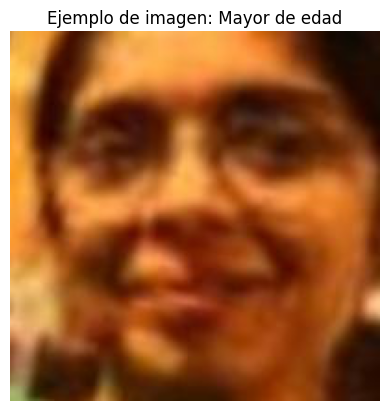

In [3]:
path = "./dataset" 

# Cargar imágenes desde la clase "Mayores_18"
train_adults_path = os.path.join(path, 'mayores_18')
image_files = os.listdir(train_adults_path)

# Cargar y mostrar la primera imagen de la clase
img_path = os.path.join(train_adults_path, image_files[0])
img = Image.open(img_path)

# Mostrar imagen en Google Colab
plt.imshow(img)
plt.axis('off')
plt.title("Ejemplo de imagen: Mayor de edad")
plt.show()

### Prueba de carga de una imagen de una persona menor de edad

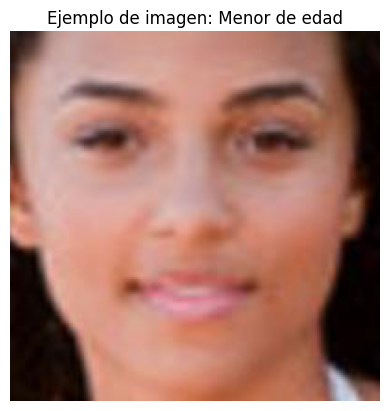

In [4]:
# Cargar imágenes desde la clase "menores_18"
train_menors_path = os.path.join(path, 'menores_18')
image_files = os.listdir(train_menors_path)

# Cargar y mostrar la primera imagen de la clase
img_path = os.path.join(train_menors_path, image_files[0])
img = Image.open(img_path)

# Mostrar imagen en Google Colab
plt.imshow(img)
plt.axis('off')
plt.title("Ejemplo de imagen: Menor de edad")
plt.show()

## **Preparación y preprocesamiento del dataset**

### Carga y preprocesamiento

In [5]:
# Ruta al directorio del dataset
dataset_path = "dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Carga y división de datos
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

print("Clases detectadas:", train_ds.class_names)

# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Confirmar clases


Found 9778 files belonging to 2 classes.
Using 7823 files for training.


2025-05-31 21:25:28.671339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 21:25:28.689742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 21:25:28.689943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 21:25:28.692457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 21:25:28.692645: I tensorflow/compile

Found 9778 files belonging to 2 classes.
Using 1955 files for validation.
Clases detectadas: ['mayores_18', 'menores_18']


In [6]:


# Cálculo basado en tu dataset actual
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=[0]*4683 + [1]*3140  # adultos=0, menores=1
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 0.8352551783045057, 1: 1.245700636942675}


## **Entrenamiento, visualización y métricas**

### Definir configuraciones a probar

In [7]:
configs = [
    {"filters": [32, 64, 128], "dense": 128, "dropout": 0.5, "epochs": 10, "activ": "relu"},
    {"filters": [64, 128], "dense": 256, "dropout": 0.4, "epochs": 15, "activ": "relu"},
    {"filters": [32, 64, 128], "dense": 128, "dropout": 0.3, "epochs": 30, "activ": "relu"},
    {"filters": [64, 128, 256], "dense": 128, "dropout": 0.4, "epochs": 30, "activ": "relu"},
]

### Borrar modelos creados anteriormente

In [8]:
archivos = [
    "models/best_model_config_1.h5",
    "models/best_model_config_1.keras",
    "models/best_model_config_2.keras",
    "models/best_model_config_3.keras",
    "models/modelo_final.keras",
    "models/modelo_final2.keras",
    "models/best_model_config_2.h5"
]

for f in archivos:
    if os.path.exists(f):
        os.remove(f)
        print(f"✅ Eliminado: {f}")
    else:
        print(f"⚠️ No encontrado: {f}")

✅ Eliminado: models/best_model_config_1.h5
⚠️ No encontrado: models/best_model_config_1.keras
⚠️ No encontrado: models/best_model_config_2.keras
⚠️ No encontrado: models/best_model_config_3.keras
✅ Eliminado: models/modelo_final.keras
⚠️ No encontrado: models/modelo_final2.keras
✅ Eliminado: models/best_model_config_2.h5


### Entrenamiento y guardado de resultados

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

results = []
histories = []

for i, cfg in enumerate(configs):
    print(f"\n Entrenando configuración {i+1}/{len(configs)}...")

    model = models.Sequential()
    model.add(layers.Input(shape=(224, 224, 3)))
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255))

    for f in cfg["filters"]:
        model.add(layers.Conv2D(f, (3, 3), activation=cfg["activ"], padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D())
    
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(
        cfg["dense"],
        activation=cfg["activ"],
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.Dropout(cfg["dropout"]))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    # Guardar el mejor modelo en formato HDF5
    checkpoint_path = f"models/best_model_config_{i+1}.h5"
    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        model_checkpoint_callback
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["epochs"],
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    histories.append({
        "name": f"Config {i+1}",
        "history": history.history
    })

    final_train_acc = history.history["accuracy"][-1]
    final_val_acc = history.history["val_accuracy"][-1]

    results.append({
        "config": i + 1,
        "filters": cfg["filters"],
        "dense": cfg["dense"],
        "dropout": cfg["dropout"],
        "epochs": cfg["epochs"],
        "activ": cfg["activ"],
        "train_acc": round(final_train_acc, 4),
        "val_acc": round(final_val_acc, 4),
        "model_file": checkpoint_path
    })


 Entrenando configuración 1/4...
Epoch 1/10


2025-05-31 21:25:55.037320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-05-31 21:25:55.853164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-31 21:25:55.918900: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3f55381b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 21:25:55.918978: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-05-31 21:25:55.949564: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-31 21:25:56.144335: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

245/245 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.6440 - auc: 0.6819
Epoch 1: val_accuracy improved from -inf to 0.66547, saving model to models/best_model_config_1.h5
245/245 [==============================] - 21s 62ms/step - loss: 0.7675 - accuracy: 0.6440 - auc: 0.6819 - val_loss: 0.7824 - val_accuracy: 0.6655 - val_auc: 0.7192
Epoch 2/10
  2/245 [..............................] - ETA: 14s - loss: 0.7074 - accuracy: 0.7031 - auc: 0.7251

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.7004 - auc: 0.7453
Epoch 2: val_accuracy did not improve from 0.66547
245/245 [==============================] - 15s 63ms/step - loss: 0.7114 - accuracy: 0.7004 - auc: 0.7453 - val_loss: 0.7517 - val_accuracy: 0.6624 - val_auc: 0.7686
Epoch 3/10
245/245 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.7284 - auc: 0.7891
Epoch 3: val_accuracy improved from 0.66547 to 0.70332, saving model to models/best_model_config_1.h5
245/245 [==============================] - 13s 53ms/step - loss: 0.6685 - accuracy: 0.7284 - auc: 0.7891 - val_loss: 0.6630 - val_accuracy: 0.7033 - val_auc: 0.8247
Epoch 4/10
245/245 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.7541 - auc: 0.8194
Epoch 4: val_accuracy improved from 0.70332 to 0.73811, saving model to models/best_model_config_1.h5
245/245 [==============================] - 16s 64ms/step - loss: 0.6298 - accuracy: 0.7541 - auc

### Calcular Threshold óptimo

In [10]:
# Obtener predicciones reales y probabilidades
y_true = []
y_scores = []

for images, labels in val_ds:
    preds = model.predict(images).flatten()
    y_scores.extend(preds)
    y_true.extend(labels.numpy())

# Calcular curvas
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calcular F1 y buscar el mejor threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f" Mejor threshold por F1-score: {best_threshold:.3f}")
print(f"Precisión: {precision[best_idx]:.2f}, Recall: {recall[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}")

1/1 [==============================] - 0s 62ms/step
 Mejor threshold por F1-score: 0.472
Precisión: 0.83, Recall: 0.86, F1: 0.85


#### Mostrar resumen de resultados

In [11]:
print(tabulate(results, headers="keys", tablefmt="fancy_grid"))

╒══════════╤════════════════╤═════════╤═══════════╤══════════╤═════════╤═════════════╤═══════════╤═══════════════════════════════╕
│   config │ filters        │   dense │   dropout │   epochs │ activ   │   train_acc │   val_acc │ model_file                    │
╞══════════╪════════════════╪═════════╪═══════════╪══════════╪═════════╪═════════════╪═══════════╪═══════════════════════════════╡
│        1 │ [32, 64, 128]  │     128 │       0.5 │       10 │ relu    │      0.7945 │    0.7959 │ models/best_model_config_1.h5 │
├──────────┼────────────────┼─────────┼───────────┼──────────┼─────────┼─────────────┼───────────┼───────────────────────────────┤
│        2 │ [64, 128]      │     256 │       0.4 │       15 │ relu    │      0.7828 │    0.7693 │ models/best_model_config_2.h5 │
├──────────┼────────────────┼─────────┼───────────┼──────────┼─────────┼─────────────┼───────────┼───────────────────────────────┤
│        3 │ [32, 64, 128]  │     128 │       0.3 │       30 │ relu    │      0.859

### Gráficos

#### Precisión

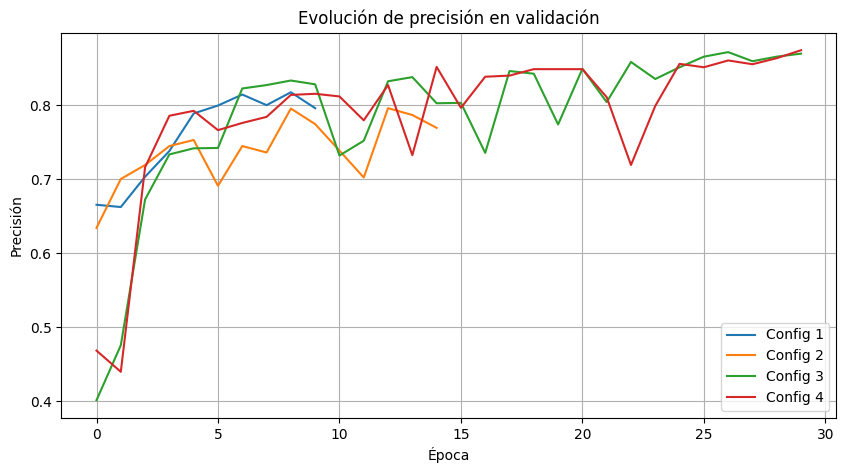

In [12]:
plt.figure(figsize=(10, 5))

for h in histories:
    plt.plot(h["history"]["val_accuracy"], label=h["name"])

plt.title("Evolución de precisión en validación")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

#### Pérdida

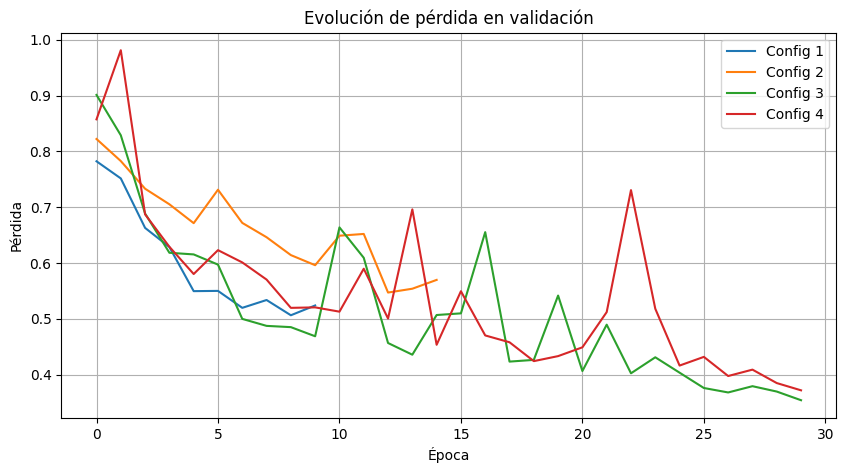

In [13]:
plt.figure(figsize=(10, 5))

for h in histories:
    plt.plot(h["history"]["val_loss"], label=h["name"])

plt.title("Evolución de pérdida en validación")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

### Evaluación del modelo con métricas

#### Obtener predicciones del modelo sobre el dataset de validación

In [14]:
best_result = max(results, key=lambda r: r["val_acc"])

best_model = load_model(best_result["model_file"])

best_model.save("models/modelo_final.keras")
print(f"Mejor modelo guardado como: models/modelo_final.keras (Config {best_result['config']})")

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.4).astype(int).flatten())

Mejor modelo guardado como: models/modelo_final.keras (Config 4)
1/1 [==============================] - 0s 68ms/step


#### Matriz de confusión

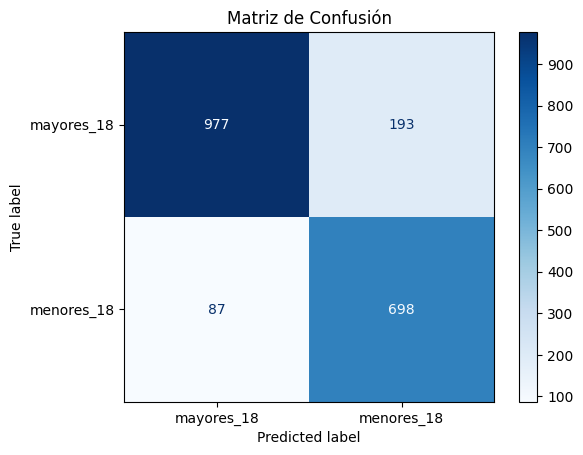

In [15]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["mayores_18", "menores_18"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

#### Visualización de métricas

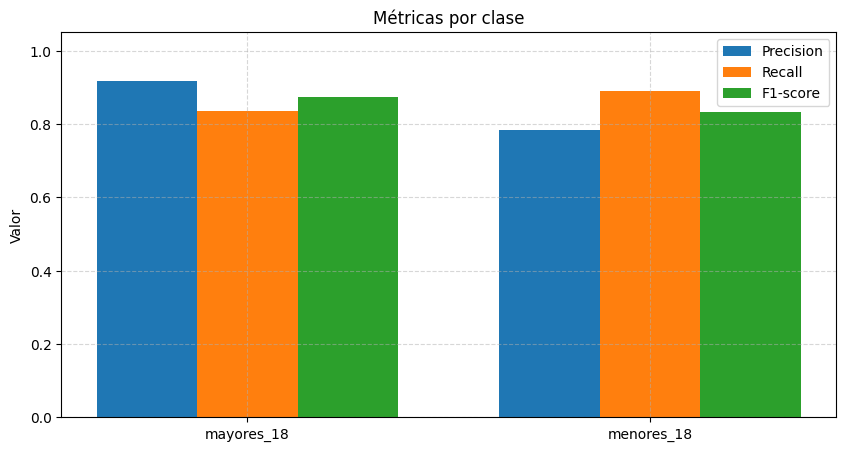

In [20]:
report = classification_report(
    y_true, y_pred,
    target_names=["mayores_18", "menores_18"],
    output_dict=True
)

# Extraer métricas por clase
labels = ["mayores_18", "menores_18"]
metrics = ["precision", "recall", "f1-score"]

values = {m: [report[label][m] for label in labels] for m in metrics}

# Gráfico de barras
x = np.arange(len(labels))  # posiciones
width = 0.25

plt.figure(figsize=(10, 5))

for i, m in enumerate(metrics):
    plt.bar(x + i*width, values[m], width, label=m.capitalize())

plt.xticks(x + width, labels)
plt.ylim(0, 1.05)
plt.ylabel("Valor")
plt.title("Métricas por clase")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### Comprobación de resultados

In [17]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.4).astype(int).flatten())

print(classification_report(y_true, y_pred, target_names=["adulto", "menor"]))

1/1 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

      adulto       0.92      0.84      0.87      1170
       menor       0.78      0.89      0.83       785

    accuracy                           0.86      1955
   macro avg       0.85      0.86      0.85      1955
weighted avg       0.86      0.86      0.86      1955



#### Recuento de clases

In [18]:
counts = Counter()
for _, labels in train_ds.unbatch():
    counts[int(labels.numpy())] += 1

print("Distribución de clases en entrenamiento:", counts)

Distribución de clases en entrenamiento: Counter({0: 4683, 1: 3140})


#### Información extra sobre las predicciones del mejor modelo

In [19]:
predicciones = best_model.predict(val_ds)
print("Media de predicciones:", np.mean(predicciones))
print("Mínima:", np.min(predicciones), "Máxima:", np.max(predicciones))

62/62 [==============================] - 2s 33ms/step
Media de predicciones: 0.43781605
Mínima: 0.0014093112 Máxima: 0.99977595
